In [2]:
from config import *
from encoders import *
from data import *
from models import *
from evals import *
print("using device: ", device)

import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# for debugging
# import importlib
# import models
# importlib.reload(models)


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


using device:  cpu


# Ugly Engineering

In [ ]:
# ugly engineering here
df = pd.read_csv('../../data/HR_events.csv')
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")
df_y = df_y[['VitalID', 'Died']]
df = df.merge(df_y, on='VitalID', how='left')
df['label'] = df.index.to_series()
# clinical events
df['cl_event'] = df['Died'].apply(lambda x: 'This infant will die in 7 days.' if x == 1 else 'This infant will survive.')
# time series events
df['ts_event1'] = df['event_description'].apply(extract_event1)
df['ts_event_summary'] = df['event_description'].apply(summarize_brady)
df['text'] = df['cl_event'] + ' ' + df['ts_event_summary'].astype(str) + ' ' + df['ts_event1'].astype(str)


df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['cl_event'])    
df_new = df_train
df_new['outcome'] = df_new['Died'].apply(lambda x: 'class1' if x == 1 else 'class2')
df_new_y = pd.get_dummies(df_new['outcome'])
y_true_train = torch.tensor(df_new_y.values)
ts_df_train = df_new.loc[:,'1':'300']
df_new = df_test
df_new['outcome'] = df_new['Died'].apply(lambda x: 'class1' if x == 1 else 'class2')
df_new_y = pd.get_dummies(df_new['outcome'])
y_true_test = torch.tensor(df_new_y.values)
ts_df_test = df_new.loc[:,'1':'300']

txt_ls = ['die in 7 days', 'survive']

# Main Usage

In [4]:
# ---- config that need to be changed ----
overwrite = False
model_name = 'clip_hr_death_summdescr'

def check_data_ready():
    required_objects = {
        'y_true_train': (pd.DataFrame, np.ndarray, torch.Tensor),
        'ts_df_train': pd.DataFrame,
        'y_true_test': (pd.DataFrame, np.ndarray, torch.Tensor),
        'ts_df_test': pd.DataFrame,
        'txt_ls': list
    }
    
    for obj_name, expected_type in required_objects.items():
        # Check if object exists in globals
        if obj_name not in globals():
            raise ValueError(f"Missing required object: {obj_name}")
        
        obj = globals()[obj_name]
        # Check if object is None
        if obj is None:
            raise ValueError(f"Object {obj_name} is None")
            
        # Check type
        if not isinstance(obj, expected_type):
            raise TypeError(f"{obj_name} should be of type {expected_type}, but got {type(obj)}")
        
        # Check if empty
        if hasattr(obj, '__len__') and len(obj) == 0:
            raise ValueError(f"{obj_name} is empty")

    print("✓ All required objects are properly defined and non-empty")
    return True
try:
    check_data_ready()
except Exception as e:
    print(f"Error: {e}")
    print("Please define all required objects before proceeding")



✓ All required objects are properly defined and non-empty


In [5]:

# ---- ready dataloader ---- 
ts_f_train, tx_f_train, labels_train = get_features(df_train,ts_encoder_name,text_encoder_name)
train_dataloader = CLIPDataset(ts_f_train, tx_f_train, labels_train).dataloader(batch_size=batch_size)
ts_f_test, tx_f_test, labels_test = get_features(df_test, ts_encoder_name,text_encoder_name)
test_dataloader = CLIPDataset(ts_f_test, tx_f_test, labels_test).dataloader(batch_size=batch_size)

# ---- ready model ---- 
model_path = './results/'+model_name+'_'+loss_type+'.pth' 
eval_path = './results/'+model_name+'_'+loss_type+'_evals.pth'
# Initialize model
model = CLIPModel(
        ts_dim=ts_f_train.shape[1],    # 32
        text_dim=tx_f_train.shape[1],  # 768
        projection_dim=embedded_dim
    )
optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=patience,          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)

/Users/joyqiu/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Layer (type:depth-idx)                   Param #
CLIPModel                                1
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       4,224
│    └─LeakyReLU: 2-2                    --
│    └─Linear: 2-3                       33,024
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       32,896
│    └─LeakyReLU: 2-6                    --
│    └─Linear: 2-7                       16,512
├─Sequential: 1-2                        --
│    └─Linear: 2-8                       98,432
│    └─LeakyReLU: 2-9                    --
│    └─Linear: 2-10                      33,024
│    └─LeakyReLU: 2-11                   --
│    └─Linear: 2-12                      65,792
│    └─LeakyReLU: 2-13                   --
│    └─Linear: 2-14                      32,896
│    └─LeakyReLU: 2-15                   --
│    └─Linear: 2-16                      16,512
Total params: 333,313
Trainable params: 333,313
Non-trainable params: 0


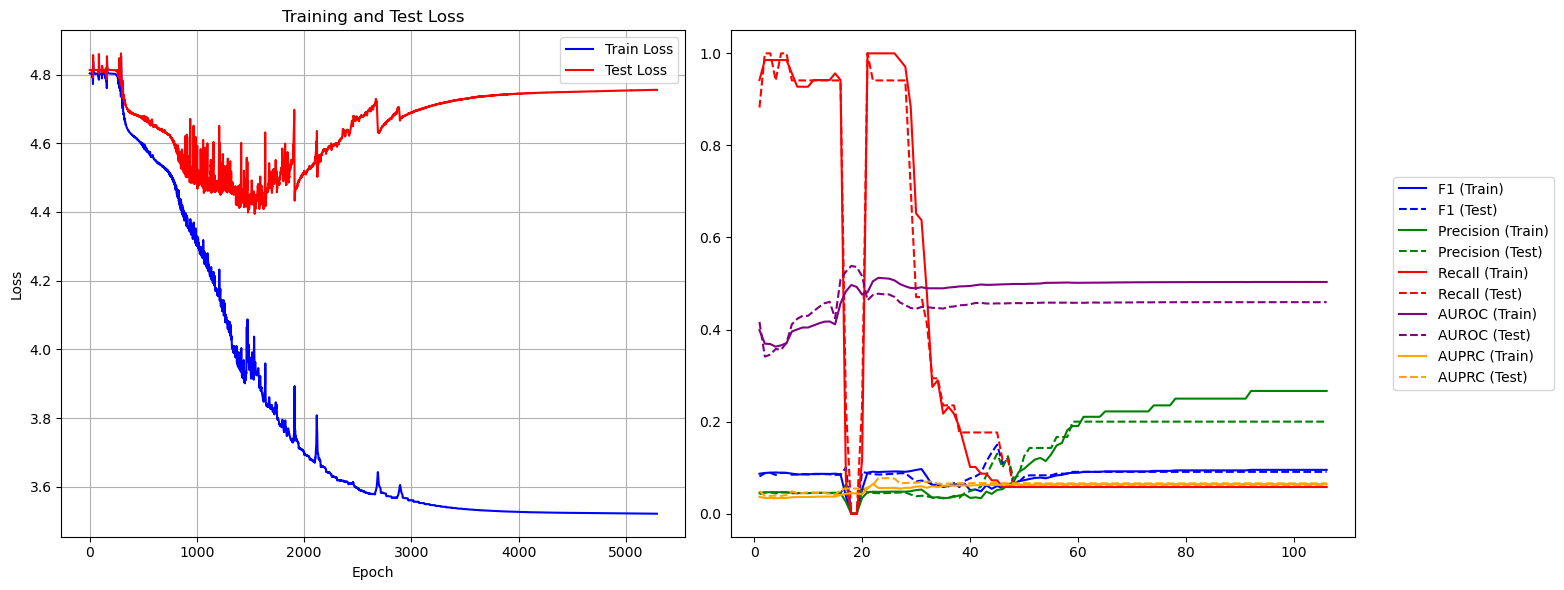

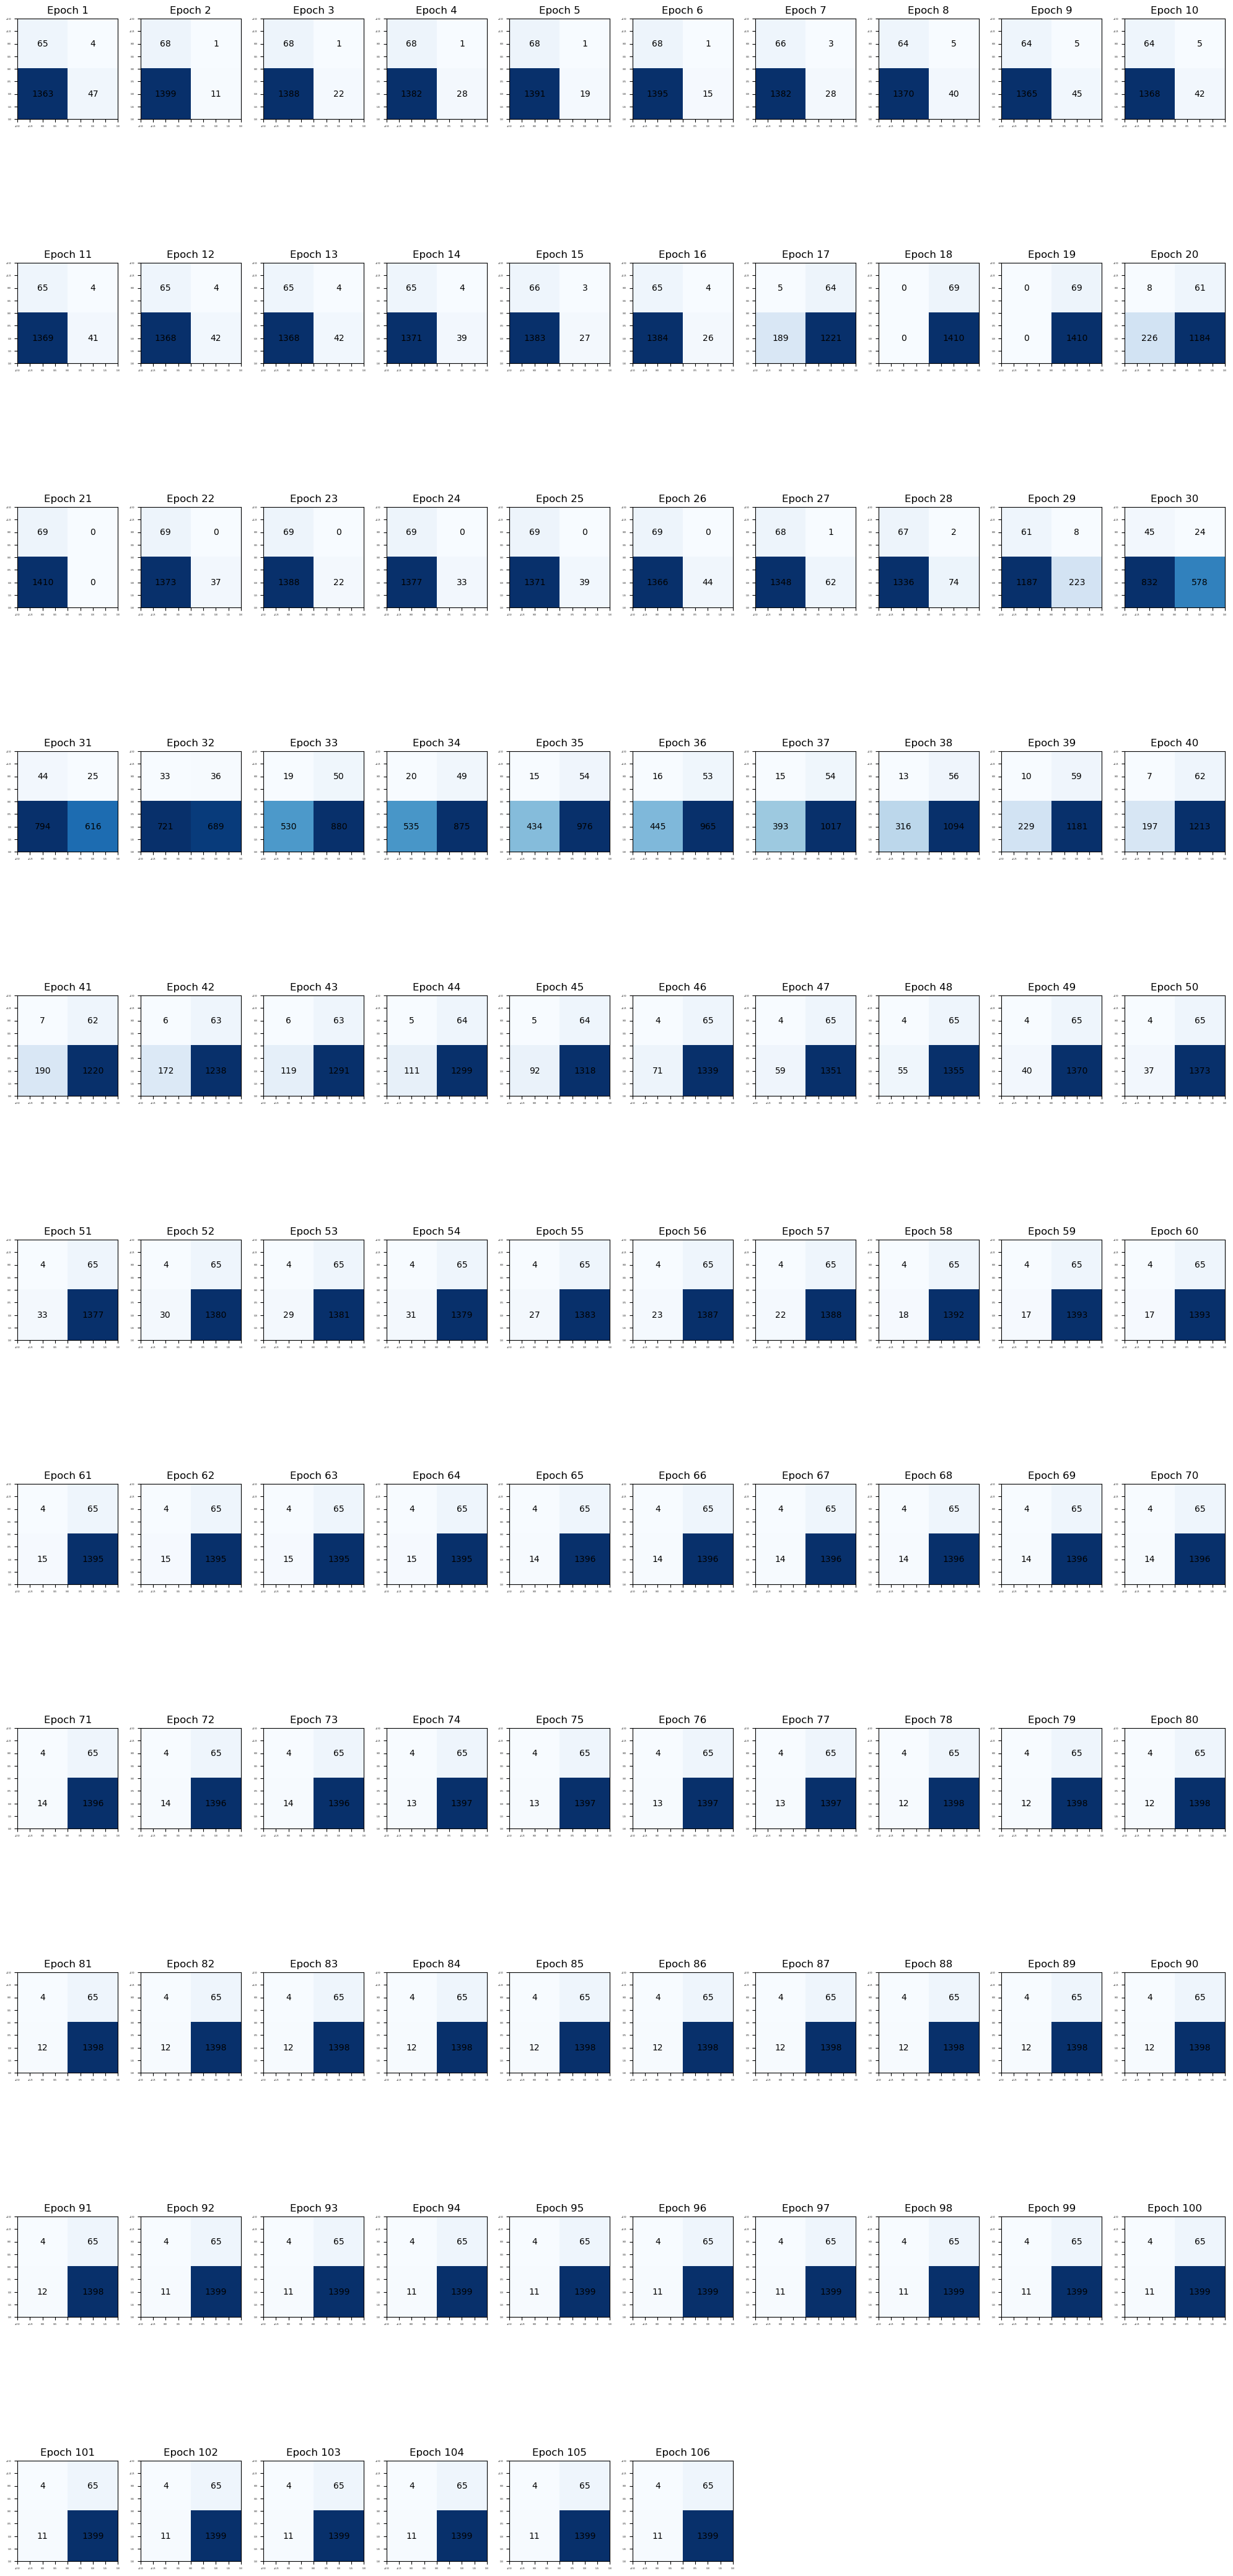

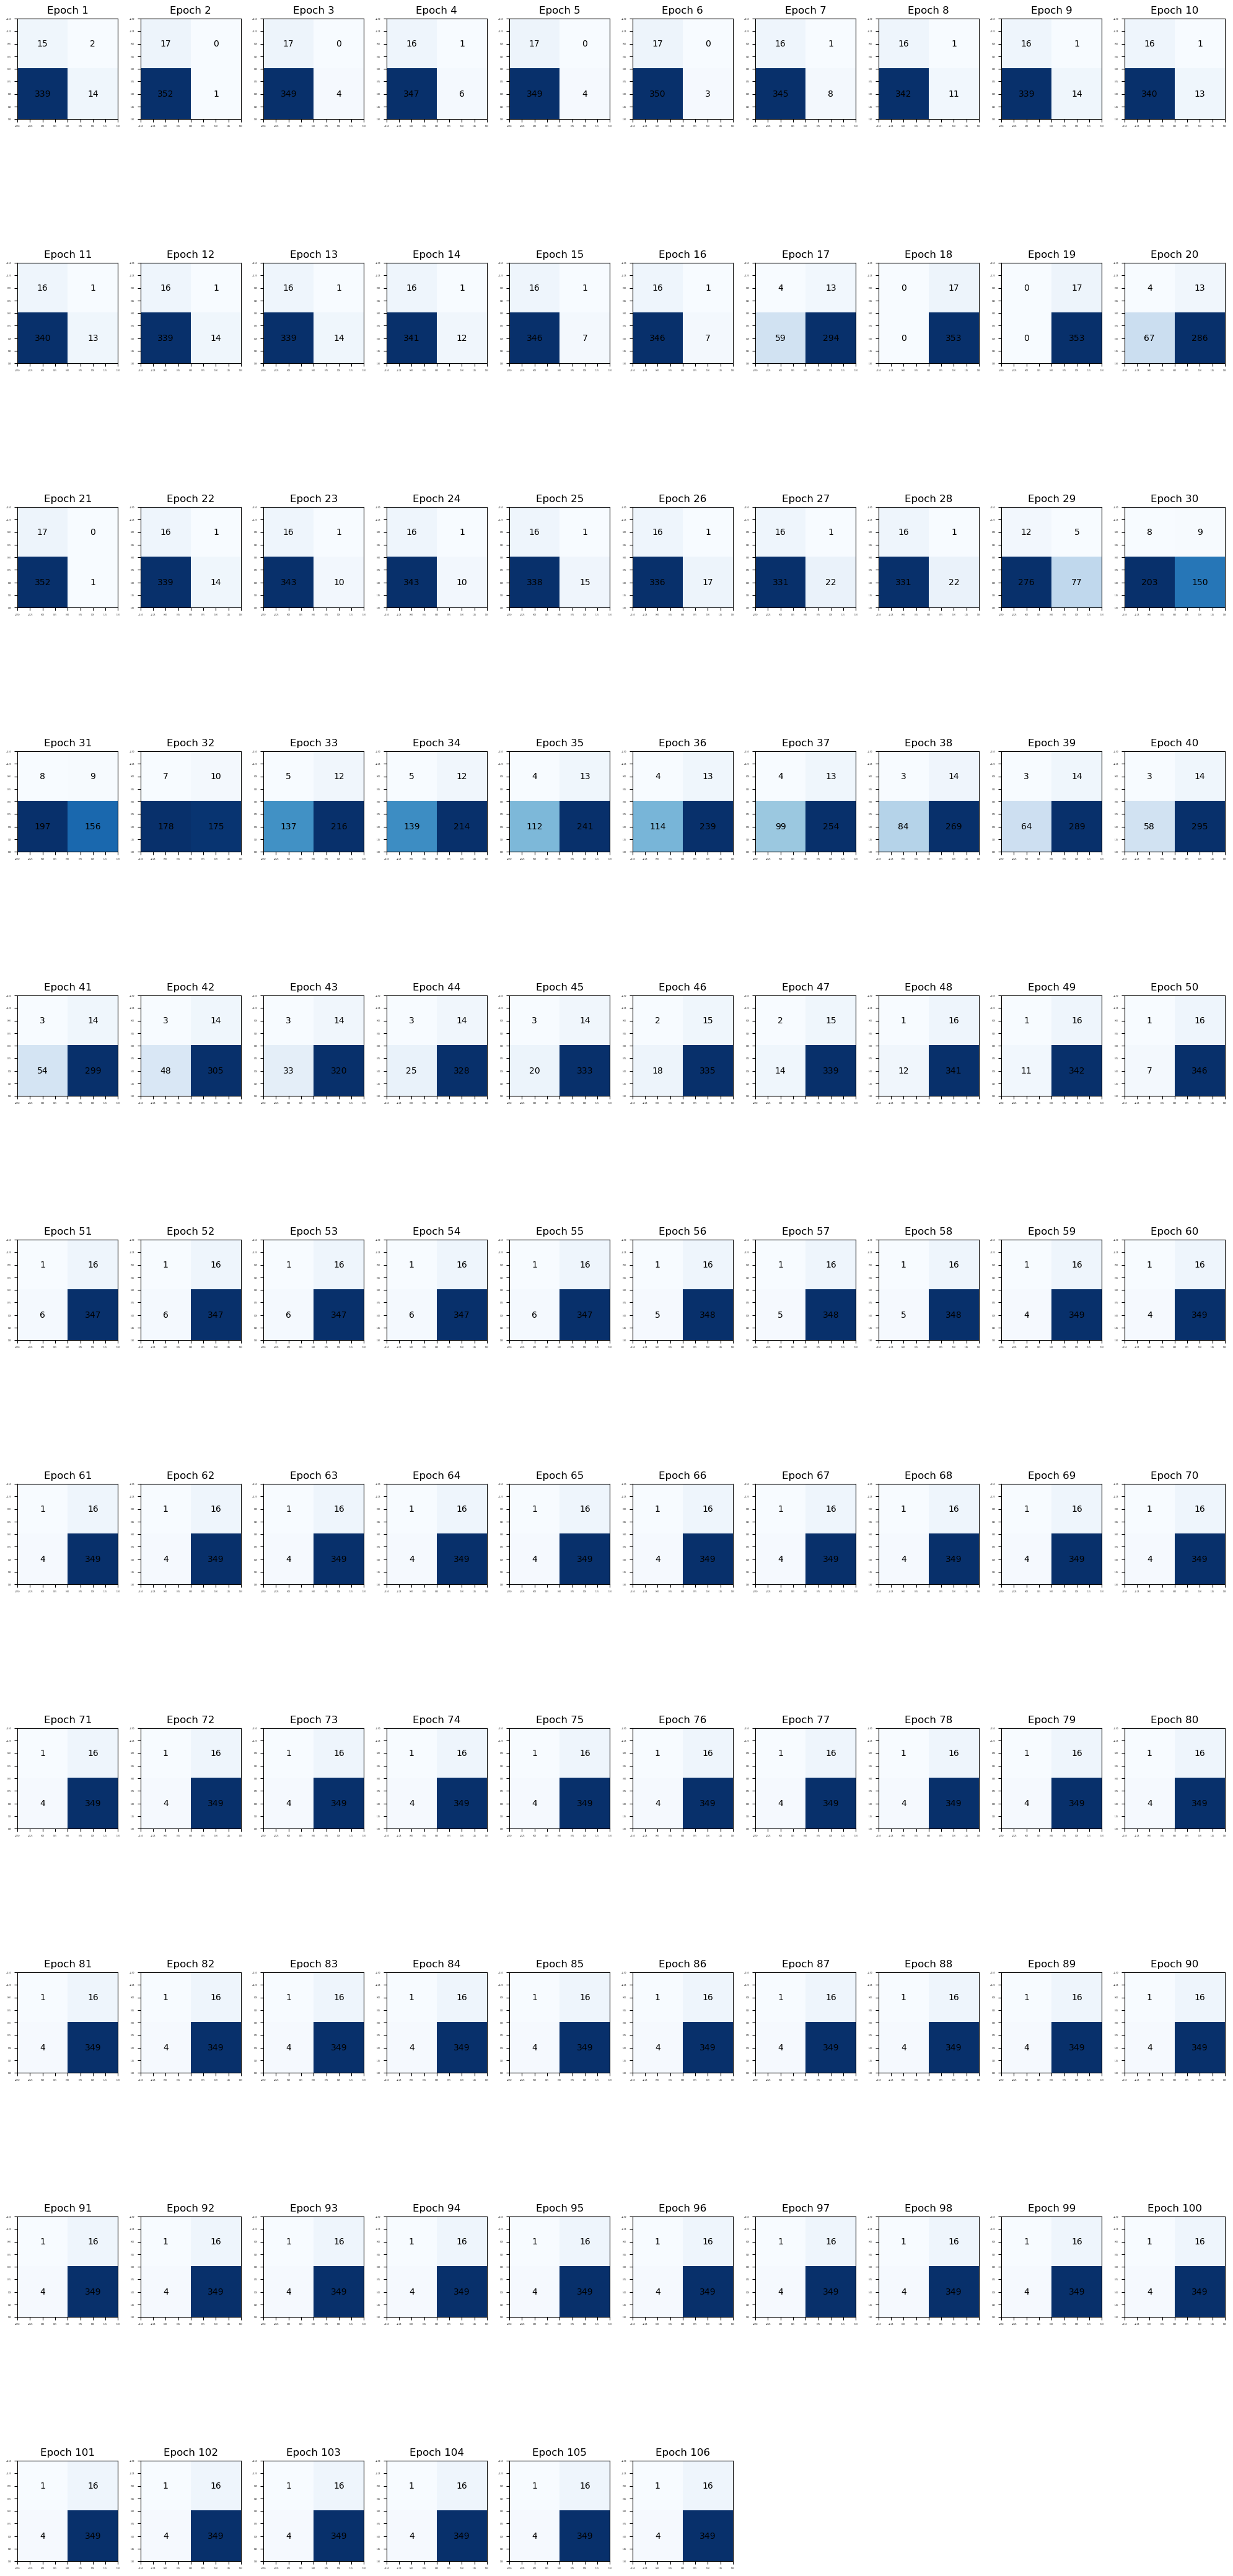

In [6]:
# ---- train and eval ---- 
if overwrite:
    # remove model_path, loss_path, eval_metrics_path
    if os.path.exists(model_path):
        os.remove(model_path)
    if os.path.exists(eval_path):
        os.remove(eval_path)
    overwrite = False # reset overwrite to False
if overwrite or not os.path.exists(model_path):
    for i in range(num_saves): 
        train_losses_tmp, test_losses_tmp = train(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                num_epochs, 
                                                device,
                                                loss_type)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        train_eval_metrics = eval_model(model, y_true_train, ts_df_train, txt_ls, ts_encoder_name, text_encoder_name)
        test_eval_metrics = eval_model(model, y_true_test, ts_df_test, txt_ls, ts_encoder_name, text_encoder_name)
        train_eval_metrics_list.append(train_eval_metrics)
        test_eval_metrics_list.append(test_eval_metrics)
        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_evals': train_eval_metrics_list,
            'test_evals': test_eval_metrics_list }, eval_path)
        if i % 10 == 0: # every 10 saves, evaluate the model
            eval_dict = torch.load(eval_path)
            eval_dict_eng = eng_eval_metrics(eval_dict, binary=True)
            print("-" * 70)
            print(f"Metric     |  Training  |  Testing")
            print("-" * 70)
            print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
            print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
            print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
            print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
            print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
            print("-" * 70)
    
else:
    model.load_state_dict(torch.load(model_path))
    eval_dict = torch.load(eval_path)
    eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot_confusion_matrices=True)